First install the repo and requirements.

In [ ]:
%pip --quiet install git+https://github.com/wilson-labs/cola.git

# PCA on Massive Datasets

In this example we will show using CoLA to perform PCA on a massive dataset.

In [13]:
import time
import torch
import cola
#from cola.basic_operations import lazify
# from cola.algorithms.svd import randomized_svd

N, D = 100000, 300
dtype = torch.float32
data = torch.randn(N, D, dtype=dtype)
print(f"Dataset (N={data.shape[0]:,d} | D={data.shape[1]:,d})")

k = 50
X = cola.lazify(data)

Dataset (N=100,000 | D=300)


In [31]:
U,S,Vh= cola.svd(X, rank=300)

tensor(0.8943) tensor(1.1139)


In [21]:
U2 = (X@Vh.H)/S

In [22]:
torch.linalg.norm(U-U2)

tensor(0.)

In [23]:
print(U.shape,S.shape,Vh.shape,X.shape)

torch.Size([100000, 300]) torch.Size([300]) torch.Size([300, 300]) torch.Size([100000, 300])


In [24]:
diff  = cola.lazify(U)@cola.diag(S)@cola.lazify(Vh) - X

In [25]:
torch.linalg.norm(diff.to_dense())/torch.linalg.norm(X.to_dense())

tensor(1.2632e-06)

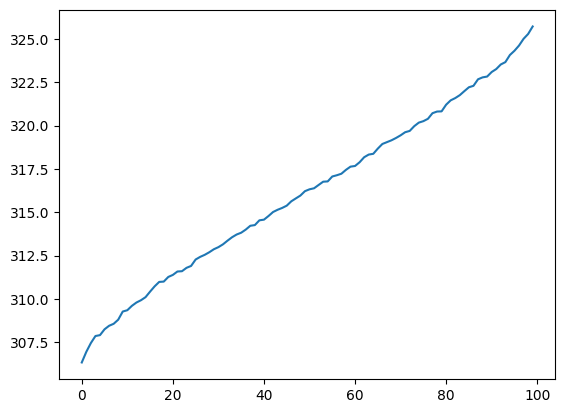

In [8]:
import matplotlib.pyplot as plt
plt.plot(S)

$X X^{T}$

# Linear Regression

In this notebook

In [12]:
import cola
import numpy as np

Phi = np.random.randn(100, 10)
y = np.random.randn(100)

In [13]:
beta = cola.pinv(cola.lazify(Phi))@y

(10, 10)
(10, 10)


In [14]:
Phi@beta-y

Array([-2.8133503e-01, -6.8498075e-01, -1.3149095e+00, -1.0082166e+00,
        2.4328026e-01, -2.5134164e-01,  1.2275592e+00, -3.6063090e-01,
        1.0228461e+00,  4.8176247e-01,  2.4515748e-02,  1.5277545e+00,
        6.9866240e-01,  6.3340616e-01, -7.6614183e-01,  1.6534162e-01,
       -2.6858121e-01, -8.3941281e-02, -1.4771845e+00,  5.0453532e-01,
        1.3546829e+00, -1.5113050e+00, -5.5564511e-01,  5.8757210e-01,
       -1.1305550e+00, -5.7743847e-01,  4.4204882e-01, -2.6575285e-01,
        9.5895636e-01, -6.6989005e-02, -9.7646546e-01, -2.1887391e+00,
       -5.7405859e-01,  4.3704781e-01,  1.1297107e-02, -1.5603948e+00,
       -7.0440865e-01, -1.8541943e-01,  7.3149502e-02, -1.9066206e-01,
        1.1392941e+00, -7.3826164e-01,  3.8223261e-01, -5.5583775e-01,
        2.3640072e+00, -1.1906821e+00, -2.0963386e-01,  1.3047632e+00,
       -4.1914463e-02,  2.8329283e-01,  1.3649665e+00, -1.6212448e-01,
        9.4806492e-01, -6.9114715e-02, -8.3822167e-01,  4.7022796e-01,
      

# Gaussian Processes

# Spectral Clustering

# Boundary Value PDEs

In this example we will show how CoLA can be used to solve linear and nonlinear boundary value PDEs.

## Laplace Equation $\Delta u = 0$

For this example we will solve the Laplace equation on an irregularly shaped domain with given boundary conditions using a finite difference discretization.

First lets create a 1000 x 1000 point coordinate mesh.

In [1]:
import numpy as np
import jax.numpy as jnp
import scipy
import jax


N=1000
ndims = 2

xgrid = jnp.linspace(-1,1,N)
xygrid = jnp.stack(jnp.meshgrid(*(ndims*[xgrid])),axis=-1)
dx = xgrid[1]-xgrid[0]
x,y = xygrid.transpose((2,0,1))

With the mesh, lets define the geometry of the PDE domain and boundary conditions. The domain need not be square as shown below. For boundary conditions, we will set them to be $B(x,y) = (x+y)\cos(2x)$ on the boundary of this domain.

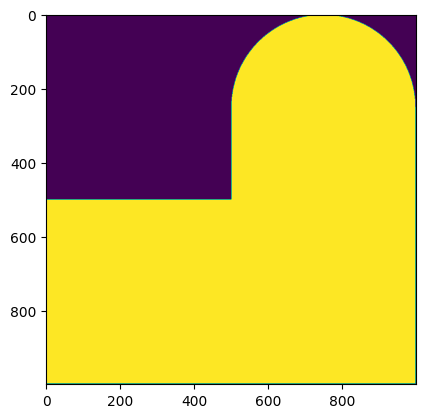

In [2]:
domain = (((x>0)|(y>0))&((y>-.5)|((x-.5)**2+(y+.5)**2<.5**2))) # chosen for example
# reduce the domain by one pixel leave space for the boundary conditions
domain &= ~(scipy.signal.convolve2d((~domain).astype(np.float32),jnp.ones((3,3)),mode='same',fillvalue=1)>0)
domain_ids, = domain.reshape(-1).nonzero()

BCS = jnp.where(domain,jnp.zeros_like(x),(x+y)*jnp.cos(2*x))


import matplotlib.pyplot as plt
plt.imshow(domain)
plt.show()


Now we need to define the Laplacian $\Delta$ as it acts on this discretized domain. 
Supposing we have the two dimensional array $v[i,j]$ representing the values on the grid, we can use the centered difference stencil for second derivatives $\partial_x^2 v(x_i,y_j) = (v[i+1, j] - 2*v[i, j] + v[i-1, j])/h^2$ + O(h^3)$.

Equivalently, we can write this as a convolution $\partial_x^2 v(x_i,y_j) =(1/h^2) (\begin{bmatrix}1& -2 &1\end{bmatrix} * v)[i,j] + O(h^3)$ where $*$ is the discrete convolution. The discretized 2d Laplacian is therefore

$Lv = (\begin{bmatrix}1& -2 &1\end{bmatrix} * v + \begin{bmatrix} 1 \\ -2 \\ 1 \end{bmatrix} *v)/h^2$. 

From this matrix vector multiply, we can define the linear operator using CoLA.

In [3]:
import cola
from jax import vmap, jit

def laplacian(x):
    x = x.reshape(ndims*(N,)) # unflatten to an ndims-dimensional grid
    cderiv = lambda x: jax.scipy.signal.correlate(x,jnp.array([1.,-2,1.])/dx**2,mode='same')
    return sum([jnp.apply_along_axis(cderiv,i,x) for i in range(ndims)]).reshape(-1)

Lfull = cola.LinearOperator(jnp.float32,shape=(N**ndims,N**ndims),matmat=jit(vmap(laplacian,-1,-1)))

Lfull is defined on the full $1000 \times 1000$ grid rather than our irregularly shaped domain. Restrict it to the domain, we just need to select the indices of the points inside the domain by slicing it, as you would a matrix.

In [4]:
L = Lfull[domain_ids,domain_ids]

Since this would ignore the boundary conditions, we can simply add them in on the right hand side.

In [5]:
RHS = -(Lfull@BCS.reshape(-1))[domain_ids]

Finally, let's solve the linear system represented by this discretized laplacian and the boundary conditions

$Lv = b$

and annotate that $L$ is a symmetric operator to speed up the computation.

In [7]:
L = cola.ops.Symmetric(L)
inv = cola.inverse(L,info=True,pbar=True)
v  = inv@RHS

Though we need to invert a $1000000 \times 1000000$ sized matrix, the solution is produced very quickly because CoLA never forms the matrix explicitly, and we can visualize the solution below.

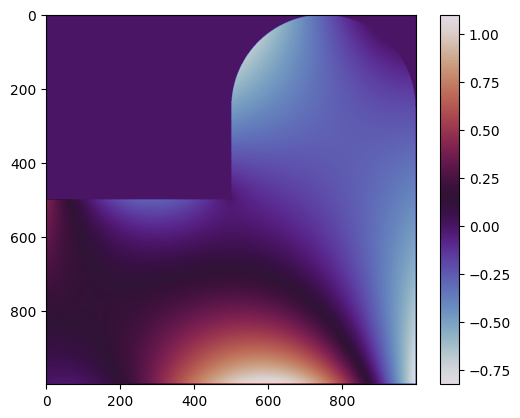

In [8]:
out_img = jnp.zeros(domain.shape)
out_img = out_img.at[domain].set(v)

plt.imshow(out_img,cmap='twilight')
plt.colorbar()
plt.show()

## Nonlinear BVP: Minimal Surface Equation

In this example we will consider solving the minimal surface equation, and example of a nonlinear boundary value PDE describing the shape of a soap bubble with a fixed boundary.
For the minimal surface, we would like to solve for the height $z$ of the surface at each point $(x,y)$ on the domain, and we make the assumption that the height is single valued.

The PDE is given by

$(1+z_x^2)z_{yy} - 2z_x z_y z_{xy} + (1+z_y^2)z_{xx}=0$

 where subscripts denote partial derivatives.
We will solve the PDE on the domain $[-1,1]^2$ with the boundary conditions

$z(x,\pm 1) = 1-x^2$ and $z(\pm 1, y) = 0$.

Before solving, first we will define the mesh and the nonlinear pde constraint.

In [9]:
N=100
xgrid = jnp.linspace(-1,1,N)
xygrid = jnp.stack(jnp.meshgrid(xgrid,xgrid),axis=-1)
dx = xgrid[1]-xgrid[0]

def pde_constraint(z):
    deriv = lambda x: jax.scipy.signal.correlate(x,jnp.array([-1/2,0,1/2])/dx,mode='same')
    deriv2 = lambda x: jax.scipy.signal.correlate(x,jnp.array([1.,-2,1.])/dx**2,mode='same')
    zx,zy = [jnp.apply_along_axis(deriv,i,z) for i in [0,1]]
    zxx,zyy = [jnp.apply_along_axis(deriv2,i,z) for i in [0,1]]
    zxy  = jnp.apply_along_axis(deriv,1,zx)
    return (1+zx**2)*zyy-2*zx*zy*zxy+(1+zy**2)*zxx

x,y = xygrid.transpose((2,0,1))
domain = (jnp.abs(x)<1)&(jnp.abs(y)<1)
boundary_vals = np.zeros_like(x)
boundary_vals[:,0] = 1-y[:,0]**2
boundary_vals[:,-1] = 1-y[:,-1]**2

@jit
def pde_constraint_on_domain(u):
    padded_domain = jnp.zeros(boundary_vals.shape)+boundary_vals
    padded_domain = padded_domain.at[domain].set(u.reshape(-1))
    padded_domain = pde_constraint(padded_domain)
    return padded_domain[domain].reshape(u.shape)

Now that we have defined the PDE constraint discretized on the domain,
we can now interpret the problem as finding the roots to a nonlinear function
$F(z)=0$ where $F$ is the discretized PDE constraint, and $z$ is a vector representing the heights at the different points on the domain.

To find the roots, we can employ Newtons method:

$z \gets z - J^{-1} F(z)$

where $J$ is the Jacobian of $z$.
While $J$ will be a large $N^2 \times N^2$ matrix, with CoLA we can perform this solve efficiently. For this we will use the CoLA [Jacobian](https://CoLA.readthedocs.io/en/latest/package/cola.ops.html#cola.ops.Jacobian) LinearOperator.

In [11]:
# Newton Raphson iteration
tol = 3e-3

z = jnp.zeros_like(x[domain]).reshape(-1) # initial guess
err = np.inf
while err > tol:
    F = pde_constraint_on_domain(z)
    err = jnp.max(jnp.abs(F))
    J = cola.ops.Jacobian(pde_constraint_on_domain,z)
    z -= cola.inverse(J)@F
    print(f"PDE Error: {err:1.1e}")

PDE Error: 2.4e+03
PDE Error: 6.8e+02
PDE Error: 2.0e+02
PDE Error: 4.0e+01
PDE Error: 1.8e+01
PDE Error: 8.3e+01
PDE Error: 1.5e+01
PDE Error: 5.0e+00
PDE Error: 3.8e+00
PDE Error: 1.1e+00
PDE Error: 1.4e-01
PDE Error: 8.6e-02
PDE Error: 2.4e-02
PDE Error: 2.4e-03


Now let's visualize the results.

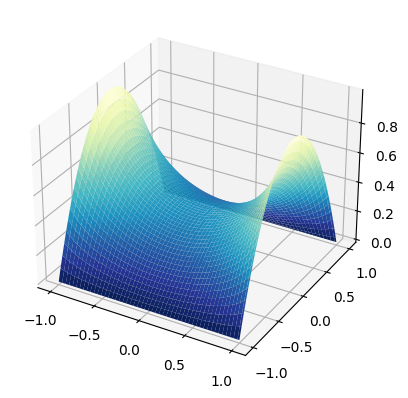

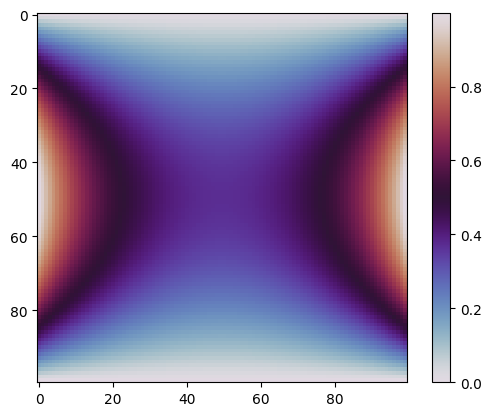

In [12]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
img = jnp.zeros(boundary_vals.shape)+boundary_vals
img = img.at[domain].set(z)
ax.plot_surface(x, y, img, cmap=plt.cm.YlGnBu_r)
plt.show()

plt.imshow(img,cmap='twilight')
plt.colorbar()
plt.show()

We see the minimal surface forms a familiar saddle shape, a solution of negative curvature like other solutions to the minimal surface equation.

# Diagonalizing a Hamiltonian (PDE eigenvalue problems)

## Solving the Schrodinger Equation for a 2d Harmonic oscillator

Solving the Schrödinger equation for a Quantum Harmonic Oscillator
In this example, we will show how to use the CoLA library to solve for the eigenvalues and eigenfunctions of the Hamiltonian operator for a two-dimensional quantum harmonic oscillator. The Hamiltonian operator is defined as

H = -Δ/2 + V(x)

where Δ is the Laplacian operator and V(x) is the potential energy function. We will be using a discretized Laplacian on a square grid and a simple harmonic potential V(x) = x²/2.

To start, let's create a 1000 x 1000 point coordinate mesh:

In [47]:
import jax.numpy as jnp
from jax import vmap, jit
import jax
import cola
from jax.config import config; config.update("jax_enable_x64", False)
#jax.config.update('jax_platform_name', 'cpu')

N = 300
ndims = 2
grid = jnp.linspace(-30,30,N)
dx = grid[1]-grid[0]
xyz = jnp.stack(jnp.meshgrid(*(ndims * [grid])), axis=-1).reshape(-1, ndims)

Here, N is the number of points in each dimension, ndims is the number of dimensions, and grid represents the grid points from -30 to 30. dx represents the grid spacing, and xyz is an array of 2D points representing the coordinates of each point in the grid.

Next, we define the Laplacian operator. We use the same finite difference stencil as in the previous example to discretize the Laplacian.

In [48]:
def laplacian(x):
    x = x.reshape(ndims*(N,)) # unflatten to an ndims-dimensional grid
    cderiv = lambda x: jax.scipy.signal.correlate(x,jnp.array([1.,-2,1.])/dx**2,mode='same')
    return sum([jnp.apply_along_axis(cderiv,i,x) for i in range(ndims)]).reshape(-1)

L = cola.ops.LinearOperator(jnp.float64, shape=(N**ndims, N**ndims), matmat=jit(vmap(laplacian, -1, -1)))

The function laplacian calculates the second derivative along each dimension and sums them up. The result is reshaped to a 1D array and returned.

Next, we define the potential function V(x) as a diagonal operator:

In [50]:
def vfn(x):
    return (x * x).sum() / 2

V = cola.diag(vmap(vfn)(xyz).reshape(-1))

vfn calculates the potential energy for a given point in the grid. cola.diag creates a diagonal operator with the calculated potential energy values on the diagonal. vmap is a function from the JAX library that applies the function vfn to each point in xyz.

Next, we define the Hamiltonian operator and compute its eigenvalues and eigenvectors:

In [53]:
H = -L / 2 + V
energy_levels, eigenfunctions = cola.eig(cola.ops.Symmetric(H))

/data/users/marc_f/cola/cola/jax_fns.py:156: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in zeros is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return jnp.zeros(shape=shape, dtype=dtype)
/data/users/marc_f/cola/cola/jax_fns.py:164: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in array is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return jnp.array(arr, dtype=dtype)


The Hamiltonian operator H is defined as the sum of the kinetic energy operator (-Δ/2) and the potential energy operator (V). The cola.ops.Symmetric function is used to inform CoLA that H is a symmetric operator which makes the eigenvalue calculation more efficient.

We then plot the lowest several eigenvalues:

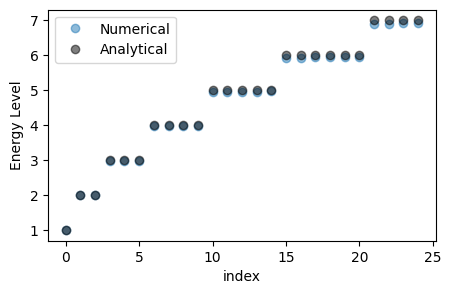

In [54]:
nm = np.stack(np.meshgrid(np.arange(10),np.arange(10)), axis=-1).reshape(-1, 2)
Enm = 1+nm[:,0]+nm[:,1]
nm = nm[Enm.argsort()]
Enm = np.sort(Enm)

import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, figsize=(5, 3))
axs.plot(energy_levels[:25], 'o',alpha=0.5, label="Numerical")
axs.plot(Enm[:25], 'o', color='k',alpha=0.5, label="Analytical")
plt.legend()
plt.xlabel("index")
plt.ylabel("Energy Level")
plt.show()

Each point represents an eigenvalue, which corresponds to an energy level of the quantum harmonic oscillator. Up to errors produced by the finite boundary (at [-30,30]) and discretization, we see the familiar $E_{nm} = (1/2+n)+(1/2+m)$ energy levels for the 2d oscillator.

Lastly, we visualize the corresponding eigenfunctions:

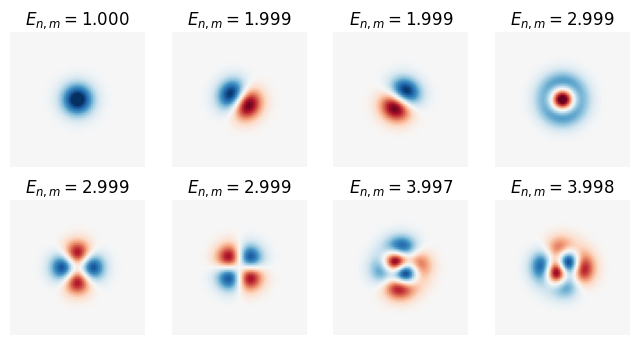

In [63]:
import numpy as np

fig, axs = plt.subplots(2, 4, figsize=(8, 4))
for i,ax in enumerate(axs.flatten()):
    l = 30
    ax.imshow(eigenfunctions[:, i].reshape(N,N)[N//2-l:N//2+l,N//2-l:N//2+l],
    extent=[grid[N//2-l],grid[N//2+l],grid[N//2+l],grid[N//2-l]],
    cmap='RdBu_r', vmin=-0.1, vmax=0.1)
    ax.set_title(r"$E_{{{}}} ={:.3f}$".format("n,m",e2[i]))
    ax.axis('off')

Each subplot represents an eigenfunction, reshaped to 2D and displayed as an image. The eigenfunctions correspond to the wave functions of the quantum harmonic oscillator at different energy levels. The color represents the value of the wave function at each point in the grid. The title of each subplot shows the corresponding eigenvalue, or energy level.

Through this example, we have shown how to solve for the energy levels and wave functions of a quantum harmonic oscillator using the CoLA library.

## Solving the Schrodinger Eq for the Hydrogen atom in 3d, diagonalizing non hermitian Hamiltonians via compactifying transform

In [ ]:
# e3 = jnp.linalg.eigvalsh(H.to_dense())
# print(np.sort(e3)[:10])

/data/users/marc_f/cola/cola/ops.py:78: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in eye is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return self @ self.ops.eye(self.shape[-1], dtype=self.dtype)


[ 41.57455   41.575943  41.576588  41.577152  41.5774    41.57964
  41.582     41.584194 152.37383  152.37447 ]


In [15]:
# import os
# import time
# import numpy as np
# import jax.numpy as jnp
# from jax import vmap, jit
# import jax
# from jax import jacfwd
# from jax.config import config
# import cola
# from jax.config import config; config.update("jax_enable_x64", True)
# jax.config.update('jax_platform_name', 'cpu')

# def square_compactification(x):
#     return jnp.arctan(x) * 2 / jnp.pi


# def inv_square_compactification(y):
#     return jnp.tan(y * jnp.pi / 2)


# # define the hydrogen atom Hamiltonian transformed coordinates
# N = 1_000
# ndims = 1

# grid = jnp.linspace(-1 + .001, 1 - .001, N)  # convert to 3d with mesgrid

# # grid = jnp.linspace(-1,1,N)
# # grid = jnp.linspace(-40,40,N)
# print(grid.dtype)
# wgrid = jnp.stack(jnp.meshgrid(*(ndims * [grid])), axis=-1).reshape(-1, ndims)
# idd = lambda x: x

# T = square_compactification  #idd#lambda x: jax.scipy.stats.norm.cdf(norm(x)/3)*x/norm(x)#jnp.log(1e-1+norm(x))*x/norm(x)#radial_hyperbolic_compactification
# Tinv = inv_square_compactification  #idd#lambda x: 3*jax.scipy.special.ndtri(norm(x))*x/norm(x)#(jnp.exp(norm(x))-1e-1)*x/norm(x)#inv_radial_hyperbolic_compactification
# xyz = vmap(Tinv)(wgrid)
# print(xyz[0], xyz[-1])
# DT = vmap(jacfwd(T))(xyz)  # (b, 3-out, 3-in)
# laplacian_factor2 = DT @ DT.transpose((0, 2, 1))
# laplacian_factor1 = vmap(lambda z: (jacfwd(jacfwd(T))(z) * jnp.eye(ndims)[None, :, :]).sum((1, 2)))(
#     xyz)
# dw = grid[1] - grid[0]
# deriv = jnp.array([-1 / 2, 0., 1 / 2]) / dw


# # deriv = jnp.array([-1.,1.])/dw
# # di = lambda x,i: sp.ndimage.correlate1d(x,deriv,axis=i,mode='constant')
# def hdiag(x):
#     cderiv = lambda x: jax.scipy.signal.correlate(x, jnp.array([1., -2, 1.]) / dw**2, mode='same')
#     dds = jnp.stack([jnp.apply_along_axis(cderiv, i, x).reshape(-1) for i in range(ndims)], axis=0)
#     embedded_diag = vmap(jnp.diag, -1, -1)(dds).transpose((2, 0, 1))
#     return embedded_diag


# jderiv = lambda x: jax.scipy.signal.correlate(x, deriv, mode='same')  # BCS?
# di = lambda x, i: jnp.apply_along_axis(jderiv, i, x)
# d = lambda x, axis=-1: jnp.stack([di(x, i) for i in range(ndims)], axis=axis)


# # lap= lambda x: scipy.ndimage.laplace(x,mode='constant')/dw**2
# def lap(x):
#     cderiv = lambda x: jax.scipy.signal.correlate(x, jnp.array([1., -2, 1.]) / dw**2, mode='same')
#     return sum([jnp.apply_along_axis(cderiv, i, x).reshape(-1) for i in range(ndims)])


# def vfn(x):
#     return (x * x).sum() / 2


# # def vfn(x):
# #     return (x*x).sum()/2


# @jit
# def laplacian(psi):
#     psi_grid = psi.reshape(*(ndims * (N, )))
#     #     return lap(psi_grid).reshape(psi.shape)
#     # return out

#     # return (hessian*jnp.eye(ndims)[None]).sum((1,2)).reshape(psi.shape)
#     dpsi = d(psi_grid)
#     hessian = d(dpsi).reshape(-1, ndims, ndims)
#     hessian = jnp.where(jnp.eye(ndims)[None] + 0 * hessian > 0.5, hdiag(psi_grid), hessian)
#     l1 = (dpsi.reshape(-1, ndims) * laplacian_factor1).sum(-1)
#     l2 = (hessian * laplacian_factor2).sum((1, 2))
#     return (l1 + l2).reshape(psi.shape)


# L = cola.ops.LinearOperator(jnp.float64, shape=(N**ndims, N**ndims),     matmat=jit(vmap(laplacian, -1, -1)))
# v = vmap(vfn)(xyz).reshape(-1)
# V = cola.diag(v)
# H = -L / 2 + V


# e2, v2, _ = cola.eig(H, method='arnoldi', max_iters=int(N * 1.))

float64
[-636.61924877] [636.61924877]


In [16]:
H.shape

(1000, 1000)

In [17]:
import numpy as np
es = np.linalg.eigvals(H.to_dense())

In [18]:
np.sort(e2)[:60]

array([-4.90754888e+03-1311.69329267j, -4.90754888e+03+1311.69329267j,
       -4.29453649e+03-1641.25722276j, -4.29453649e+03+1641.25722276j,
       -3.84794755e+03-1858.37727594j, -3.84794755e+03+1858.37727594j,
       -3.48252843e+03-2016.43973032j, -3.48252843e+03+2016.43973032j,
       -3.16767199e+03-2136.5828298j , -3.16767199e+03+2136.5828298j ,
       -2.88830824e+03-2229.78326565j, -2.88830824e+03+2229.78326565j,
       -2.63571636e+03-2302.61280987j, -2.63571636e+03+2302.61280987j,
       -2.40431751e+03-2359.37542428j, -2.40431751e+03+2359.37542428j,
       -2.19028874e+03-2403.07100833j, -2.19028874e+03+2403.07100833j,
       -1.99087537e+03-2435.8888709j , -1.99087537e+03+2435.8888709j ,
       -1.80401439e+03-2459.48436367j, -1.80401439e+03+2459.48436367j,
       -1.62811452e+03-2475.14347346j, -1.62811452e+03+2475.14347346j,
       -1.46191924e+03-2483.90006492j, -1.46191924e+03+2483.90006492j,
       -1.30435261e+03-2486.5542206j , -1.30435261e+03+2486.5542206j ,
      

In [19]:
np.sort(es)[:20]

array([ 0.49999913,  1.49999185,  2.49997236,  3.49992991,  4.49985116,
        5.49971871,  6.49951162,  7.49920517,  8.49877097,  9.49817688,
       10.49738703, 11.49636184, 12.49505793, 13.49342818, 14.49142167,
       15.48898368, 16.48605563, 17.48257509, 18.47847573, 19.47368727])